<a href="https://colab.research.google.com/github/gsurend4/BackPropogration/blob/main/01_Pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

from torch import nn

import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cu126'

## Workflow

1. Data (prepare and load)
2. Build Model
3. Fitting the Model to the data (Model Training)
4. Making Predictions and Evaluating the Model (Model Evaluating)
5. Saving and Loading the Model
6. Putting all together

## 01. Data (Preparation and Loading)

In [2]:
# parameters
weight = 0.7
bias = 0.3

# Linear Regression Model --> y = mx + b
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # increasing 1 dim

y = weight * X + bias

# X, y

In [3]:
len(X), len(y)

(50, 50)

In [4]:
# Splitting the data : Training data vs Test data

train_split = int(0.8 * len(X))
# 40 data

X_train, y_train = X[:train_split], y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]


Plotting the data points

In [5]:
def data_plot(train_data = X_train,
              train_labels = y_train,
              test_data = X_test,
              test_labels = y_test,
              predictions = None):

    plt.figure(figsize = (10,7))

    plt.scatter(train_data, train_labels, c = 'b', s = 4, label = 'train_data')

    plt.scatter(test_data, test_labels, c = 'g', s = 4, label = 'test_data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c = 'r', s = 4, label = 'predictions')

    plt.legend()

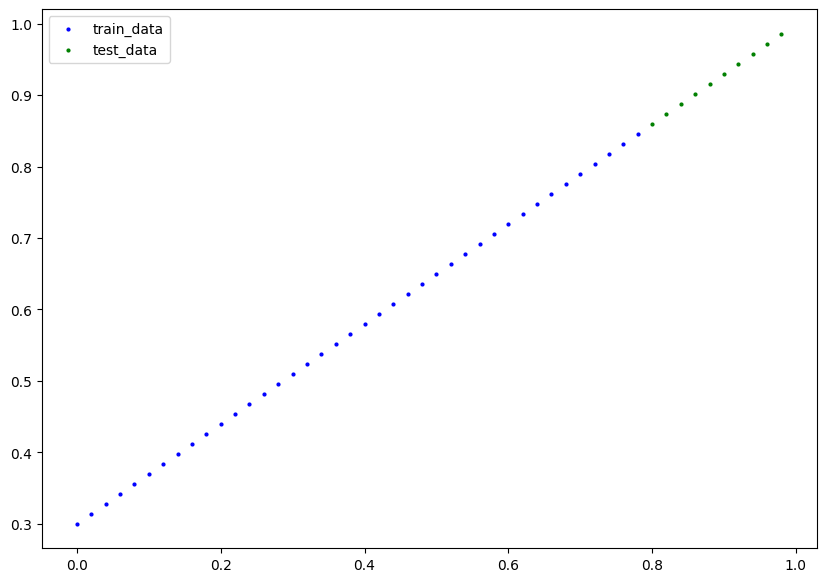

In [6]:
data_plot()

## 02. Build Model

In [7]:
class LinearRegressionModel(nn.Module): # Inheritance
    def __init__(self):
        super().__init__()
        #  nn.Parameter --> automatically added to the list of the Model parameters
        self.weights = nn.Parameter(torch.randn(1,
                                   requires_grad=True,
                                   dtype = torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                requires_grad=True,
                                dtype = torch.float))
    # forward pass
    def forward(self, x:torch.Tensor) -> torch.Tensor: # return type is also torch.Tensor
        return self.weights * x + self.bias # Regression formula y = mx + b


    # return value
    def __repr__(self) -> str:
        return "Custom Linear Model"

In [8]:
# random seed to have constant value
torch.manual_seed(42)

# Instance of the Model
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
model_0.